<img src="logo_UCLA_blue_boxed.svg" alt="ucla logo" width="150" align="left"/>

### **MAE 150A - Intermediate Fluid Mechanics**

<hr />

# Viscous flow past a stationary body

In this notebook, we will solve the Navier-Stokes equations for the flow past a stationary body. Although the body is stationary and the freestream flow is constant, the flow itself will be unsteady. This is because we assume that the flow starts at rest and then suddenly turns on at t = 0. We assume that there are no walls near the body---it is called an *external flow*.

We will assume that the flow is two-dimensional. For this reason, we are relatively limited in the range of Reynolds numbers we will study: essentially, Re = 1000 is about as large as we are prepared to go.

The tools here allow you to set up a wide variety of body shapes, including airfoils, circles, rectangles, flat plates, or more abstract shapes.

### Set up the module

The first time you run this notebook, this part can take a while because it has to precompile the code. So be patient. The later steps are pretty fast. The next line checks that the code is up to date with the lastest tools.

In [59]:
using Pkg
pkg"update"

  Updating registry at `~/.julia/registries/General`
  Updating git-repo `https://github.com/JuliaRegistries/General.git`
Fetching: [========================================>]  100.0 %.0 %  Updating git-repo `https://github.com/darwindarak/PotentialFlow.jl.git`
  Updating git-repo `https://github.com/jdeldre/ViscousFlow.jl.git`
Fetching: [========================================>]  100.0 %.0 % Resolving package versions...
 Installed DataStructures ─ v0.17.9
  Updating `~/Dropbox/MAE150A/Julia/MAE150A/Project.toml`
 [no changes]
  Updating `~/Dropbox/MAE150A/Julia/MAE150A/Manifest.toml`
  [864edb3b] ↑ DataStructures v0.17.8 ⇒ v0.17.9


In [1]:
using MAE150A

┌ Info: Recompiling stale cache file /Users/jeff/.julia/compiled/v1.2/MAE150A/A9IAL.ji for MAE150A [a017625c-406c-46ee-99d6-0fac6062339e]
└ @ Base loading.jl:1240


In [2]:
using DelimitedFiles

In [59]:
using LaTeXStrings

### Solve flow past a stationary airfoil

Set the flow parameters

In [4]:
Re = 1000; # Reynolds number
U = 1.0; # Free stream velocity
U∞ = (U,0.0);

Set the domain size and time step size

In [5]:
Δx = 0.01

0.01

Open an airfoil data file

In [7]:
pts, header = readdlm("airfoils/naca4415.dat",Float64,header=true)

([1.0 0.0; 0.99893 0.00039; … ; 0.99893 -0.00011; 1.0 0.0], AbstractString["NACA" "4415"])

In [8]:
body = SplinedBody(pts,Δx);

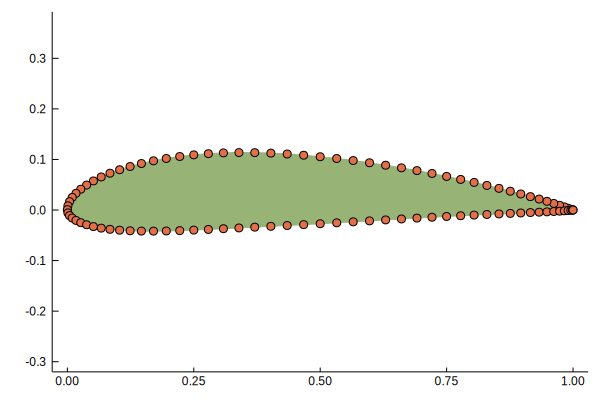

In [9]:
plot(body)
scatter!(pts[:,1],pts[:,2])

Transform the body with a specified initial position and orientation.

In [10]:
cent = (-0.5,0.0) #1.0+1.0im
α = -5π/180 #-π/3 #-π/4
T = RigidTransform(cent,α)
T(body) # transform the body to the current configuration

Basic pointwise-specified body with 206 points
   Current position: (-0.5,0.0)
   Current angle (rad): -0.08726646259971647


Set up the domain

In [11]:
xlim = (-1.0,4.0)
ylim = (-1.0,1.0)

(-1.0, 1.0)

Plot the body in the flow domain, just to make sure it looks as expected

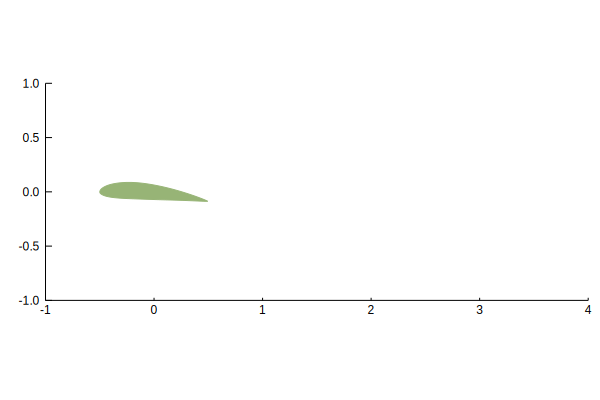

In [12]:
plot(body,xlim=xlim,ylim=ylim)

### Now set up the system

Set up the system and solver here

In [13]:
solver, sys, state0, f = initialize_ns_solver(Re,U∞,Δx,xlim,ylim,body)

(Order-3 IF-HERK integrator with
   State of type Nodes{Dual,504,208,Float64}
   Force of type VectorData{206,Float64}
   Time step size 0.005
, Navier-Stokes system on a grid of size 504 x 208, Dual nodes in a (nx = 504, ny = 208) cell grid of type Float64 data
  Number of Dual nodes: (nx = 504, ny = 208), [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])

Initialize the state vector

In [14]:
t = 0.0
state0 .= 0.0
state = deepcopy(state0)
nothing

### Advance the system

Set the time range to integrate over.

In [24]:
tf = 6
T = sys.Δt:sys.Δt:tf

0.005:0.005:6.0

Initialize the storage of solution data

In [16]:
# integrated force components on the body
fx = Float64[]
fy = Float64[]
thist = Float64[]

# state vector data
tmin_store = 0.0
tmax_store = 100.0
tsample = 0.1
S = StorePlan(tmin_store,tmax_store,tsample,state,f,t,htype=RegularHistory)
data_history = initialize_storage(S)
nothing

Advance the solution

In [25]:
for iter in eachindex(T)
    global t, state, f = solver(t,state)
    
    store_data!(data_history,t,S,deepcopy(state),deepcopy(f),t)
    
    push!(thist,t)
    push!(fx,sum(f.u)*Δx^2)
    push!(fy,sum(f.v)*Δx^2)
    
end
println("solution completed through time t = ",t)

solution completed through time t = 6.19999999999989


Save the current solution data in a file

In [78]:
save_ns_solution("NACA4415_5deg.jld",sys,body,state,f)

#### Plotting

In [27]:
xg, yg = coordinates(state,sys.grid)

(-1.0150000000000001:0.01:4.015, -1.035:0.01:1.035)

In [28]:
iplot = length(data_history[1]) # index of time step for plotting
u, ω, ψ = get_flowfield(data_history[1][iplot],sys);
nothing

Plot the vorticity field

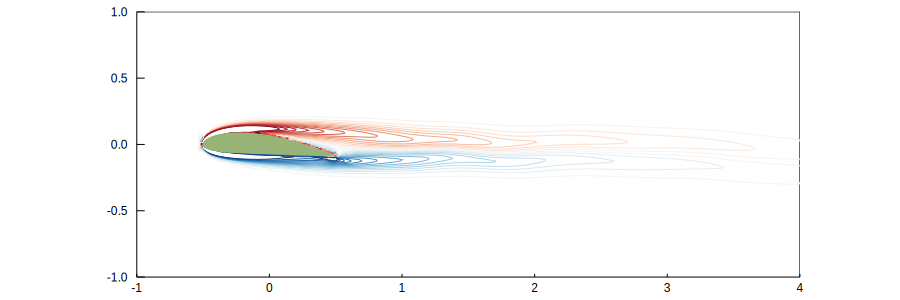

In [35]:
plot(xg,yg,ω,levels=range(-15,15,length=30), color = :RdBu,clim=(-15,15),ylim=(-1,1),xlim=(-1,4),size=(900,300))
plot!(body)

Plot the streamlines

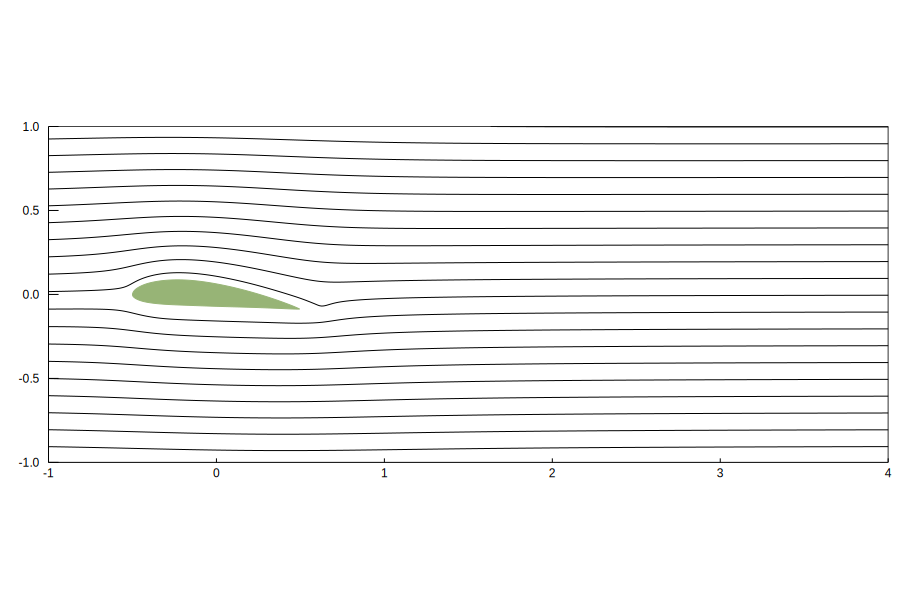

In [22]:
plot(xg,yg,ψ,levels=range(-1,2,length=31), color = :black, ylim = (-1,1),xlim = (-1,4),size=(900,600))
plot!(body)

Plot lift and drag coefficient

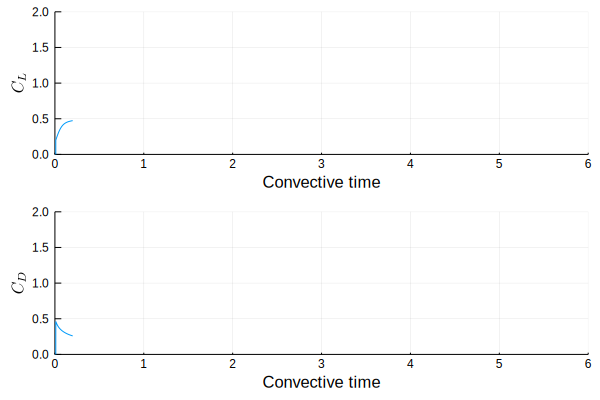

In [23]:
plt = plot(layout = (2,1), size = (600, 400))
plot!(plt[1],thist,2*fy,xlim=(0,6),ylim=(0,2),xlabel="Convective time",ylabel="\$C_L\$",legend=false)
plot!(plt[2],thist,2*fx,xlim=(0,6),ylim=(0,2),xlabel="Convective time",ylabel="\$C_D\$",legend=false)
plt

### Look at particle trajectories

In [51]:
x0 = [-1.0,0]
Tmax = 5.0
Δt = 0.001
sol = compute_trajectory(u,sys,x0,Tmax,Δt);

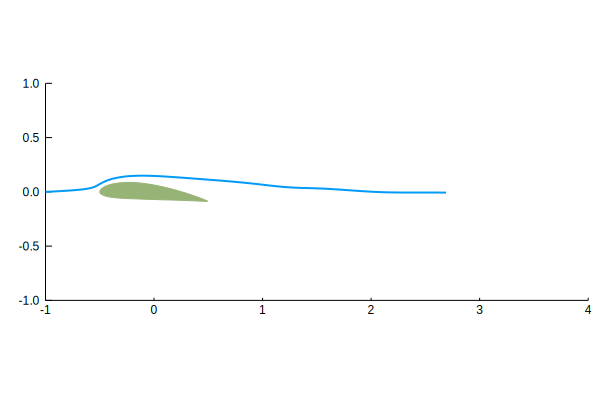

In [52]:
plot(sol[1,:],sol[2,:],linewidth=2,xlim=(-1,4),ylim=(-1,1))
plot!(body)